### The Word2Vec Model

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

    1.The Continuous Bag of Words (CBOW) Model
    2.The Skip-gram Model 

https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html
https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
CONTEXT_SIZE = 2

text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()



In [12]:
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size: ', vocab_size)

w2i = {w:i for i, w in enumerate(vocab)}
i2w = {i:w for i, w in enumerate(vocab)}

vocab_size:  49


In [13]:
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text)-2):
        context = [text[i-2], text[i-1], 
                   text[i+1], text[i+2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text)-2):
        # contextually relevant pair
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        
        for _ in range(4):
            if  i >= len(text)-3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            # contextually irrelevant pair
            data.append((text[i], text[rand_id], 0))
                        
    return data
                
            

In [14]:
len(text)

62

In [15]:
cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)


In [16]:
for _ in range(len(skipgram_train)):
    print(skipgram_train[_])

('about', 'We', 1)
('about', 'are', 1)
('about', 'to', 1)
('about', 'study', 1)
('about', 'idea', 0)
('about', 'beings', 0)
('about', 'evolve,', 0)
('about', 'computational', 0)
('to', 'are', 1)
('to', 'about', 1)
('to', 'study', 1)
('to', 'the', 1)
('to', 'As', 0)
('to', 'are', 0)
('to', 'computational', 0)
('to', 'data.', 0)
('study', 'about', 1)
('study', 'to', 1)
('study', 'the', 1)
('study', 'idea', 1)
('study', 'to', 0)
('study', 'conjure', 0)
('study', 'evolve,', 0)
('study', 'we', 0)
('the', 'to', 1)
('the', 'study', 1)
('the', 'idea', 1)
('the', 'of', 1)
('the', 'things', 0)
('the', 'processes', 0)
('the', 'directed', 0)
('the', 'called', 0)
('idea', 'study', 1)
('idea', 'the', 1)
('idea', 'of', 1)
('idea', 'a', 1)
('idea', 'of', 0)
('idea', 'manipulate', 0)
('idea', 'our', 0)
('idea', 'abstract', 0)
('of', 'the', 1)
('of', 'idea', 1)
('of', 'a', 1)
('of', 'computational', 1)
('of', 'a', 0)
('of', 'we', 0)
('of', 'Computational', 0)
('of', 'other', 0)
('a', 'idea', 1)
('a', 'o

In [17]:
# you need to specify nn.Module correctly in the brackets to inherit the class of Neural 
#network for the CBOW 
# Here, you’ve used super() to call the __init__() of the nn.Module class allowing to use it 
# in CBOW class. In this example, nn.Module is the superclass, and CBOW is the subclass.

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1,-1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        logs_probs = F.log_softmax(out)
        return logs_probs
        

In [35]:
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(Skipgram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
        
        return log_probs

In [19]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30
hidden_size = 64

In [20]:
cbow_train[0]

(['We', 'are', 'to', 'study'], 'about')

In [36]:
def train_cbow():
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train: 
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))
            
            model.zero_grad()
            log_probs = model(ctx_var)
            
            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))
            
            loss.backward()
            optimizer.step()
            # we add the loss of each row of dataset. 
            total_loss += loss.data
            
        losses.append(total_loss)
    return model, losses

In [39]:
def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = Skipgram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    
    for epoch in range(n_epoch):
        total_losses = .0
        for in_word, out_word, target in skipgram_train:
            total_loss = .0
            in_word_var = Variable(torch.LongTensor([w2i[in_word]]))
            out_word_var = Variable(torch.LongTensor([w2i[out_word]]))
            
            model.zero_grad() 
            
            log_probs =  model(in_word_var, out_word_var)
            # Notice that the ind 0 in logs_probs indicate that we keep only the first predicted proba
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
            loss.backward()
            optimizer.step()
            total_loss += loss.data
        losses.append(total_loss)
    return model, losses
            
            
            

In [40]:
cbow_model, cbow_losses = train_cbow()
skipgram_model, skipgram_losses = train_skipgram()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


C:\Users\justi\AppData\Local\Temp\ipykernel_18404\3268549838.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logs_probs = F.log_softmax(out)


Skipgram(
  (embeddings): Embedding(49, 100)
)


In [47]:
def test_cbow(test_data, model):
    print('====== Test CBOW ====')
    correct = 0
    for ctx, target in test_data:
        ctx_ids = [w2i[word] for word in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_ids))
        
        model.zero_grad()
        logs_prob = model(ctx_var)
        _, predicted = torch.max(logs_prob, 1)
        predicted_word = i2w[predicted.item()]
        print('predicted:', predicted_word)
        print('label :', target)
        if predicted_word == target:
            correct +=1
            
    print('Accuracy : {:.1f}% ({:d}/{:d})'.format(correct*100/len(test_data), correct, len(test_data)))
    

In [48]:
def test_skipgram(test_data, model):
    print('===== Test Skipgram ===')
    correct = 0
    for in_w, out_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
        
        model.zero_grad()
        logs_prob = model(in_w_var, out_w_var)
        _, predicted = torch.max(logs_prob, 1)
        # I don't understand very well the ind 0 in the brackets
        predicted = predicted[0]
        if predicted == target : 
            correct += 1
            
    print('Accuracy : {:.1f}% ({:d}/{:d})'.format(correct*100/len(test_data), correct, len(test_data)))

In [49]:
test_cbow(cbow_train, cbow_model)

====== Test CBOW ====
predicted: about
label : about
predicted: to
label : to
predicted: study
label : study
predicted: the
label : the
predicted: idea
label : idea
predicted: of
label : of
predicted: a
label : a
predicted: computational
label : computational
predicted: process.
label : process.
predicted: Computational
label : Computational
predicted: processes
label : processes
predicted: are
label : are
predicted: abstract
label : abstract
predicted: beings
label : beings
predicted: that
label : that
predicted: inhabit
label : inhabit
predicted: computers.
label : computers.
predicted: As
label : As
predicted: they
label : they
predicted: evolve,
label : evolve,
predicted: processes
label : processes
predicted: manipulate
label : manipulate
predicted: other
label : other
predicted: abstract
label : abstract
predicted: things
label : things
predicted: called
label : called
predicted: data.
label : data.
predicted: The
label : The
predicted: evolution
label : evolution
predicted: of
l

C:\Users\justi\AppData\Local\Temp\ipykernel_18404\3268549838.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logs_probs = F.log_softmax(out)


In [50]:
test_skipgram(skipgram_train, skipgram_model)

===== Test Skipgram ===
Accuracy : 50.0% (232/464)


<Figure size 432x288 with 0 Axes>

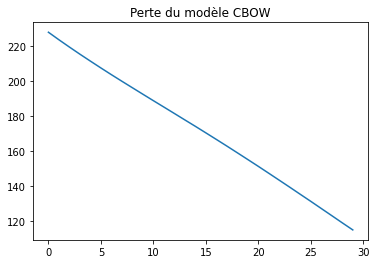

<Figure size 432x288 with 0 Axes>

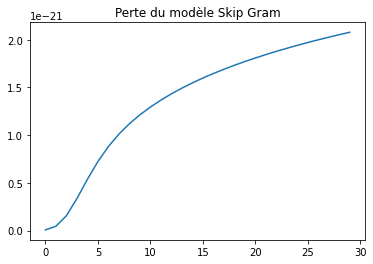

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.title(title)
    
showPlot(cbow_losses, "Perte du modèle CBOW")
showPlot(skipgram_losses, "Perte du modèle Skip Gram")

### GLOVE model Representation of vectors

In [55]:
# pip install torchtext

In [56]:
import torch
import torchtext.vocab as vocab
glove = vocab.GloVe(name = "6B", dim=100)
print("Loaded {} words".format(len(glove.itos)))

.vector_cache\glove.6B.zip: 862MB [02:49, 5.07MB/s]                               
100%|█████████▉| 399999/400000 [00:20<00:00, 19137.23it/s]


Loaded 400000 words


In [57]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [58]:
get_word("google")

tensor([ 0.2257, -0.5625, -0.0516, -0.0794,  1.1876, -0.4840, -0.2334, -0.8528,
         0.9750, -0.3334,  0.7169,  0.1264,  0.3196, -1.4136, -0.5790, -0.0373,
        -0.0164,  0.4516, -0.2900,  0.5260, -0.2253, -0.2956, -0.0324,  1.5608,
        -0.0135, -0.0646,  0.2663,  0.7860, -0.7169, -0.9302,  0.8046,  1.6035,
        -0.3060, -0.3476,  0.9387,  0.3814, -0.2674, -0.5652,  0.5890, -0.1455,
        -0.3432,  0.2129, -0.3989,  0.0900, -0.8495,  0.3880, -0.5045, -0.2249,
         1.0644, -0.2624,  1.0334,  0.0635, -0.3999,  0.2424, -0.6564, -1.8107,
        -0.0618,  0.1380,  1.1658, -0.3005, -0.5014,  0.1651,  0.0398,  0.6254,
         0.5694,  0.6413,  0.2131,  0.3028,  0.3967,  0.3897,  0.2818,  0.7948,
        -0.1196, -0.4960, -0.5319, -0.1490,  0.5125, -0.3921, -0.5853, -0.0785,
         0.8172, -0.7350, -0.6813,  0.0992, -0.8761,  0.0296,  0.3340, -0.1431,
         0.1696, -0.0352,  0.3978,  0.7177,  0.2587, -0.3620,  0.4570, -0.3916,
        -0.4934, -0.1122,  0.2905,  0.73

In [74]:
a = list(['samy', 'justin', 'ayivi', 'ferrat'])

In [80]:
sorted(a)

['ayivi', 'ferrat', 'justin', 'samy']

In [81]:
student_tuples = [('dave', 'B', 12),('justin', 'A', 10), ('ayivi', 'C', 13)]
sorted(student_tuples, key = lambda t:t[1])[:2]

[('justin', 'A', 10), ('dave', 'B', 12)]

In [82]:
def closest(vec, n = 10):
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
    return sorted(all_dists, key = lambda t: t[1])[:n]

In [90]:
def print_tuples(tuples):
    for tuple in tuples : 
        print("(%.4f) %s" % (tuple[1], tuple[0]))

In [91]:
print_tuples(closest(get_word("google")))

(0.0000) google
(3.0772) yahoo
(3.8836) microsoft
(4.1048) web
(4.1082) aol
(4.1165) facebook
(4.3917) ebay
(4.4122) msn
(4.4540) internet
(4.4651) netscape


In [92]:
def analogy(w1, w2, w3, n=5, filter_given = True):
    print('\n[%s : %s :: %s :?]' % (w1, w2, w3))
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1,w2,w3]]
    print_tuples(closest_words[:n])

In [93]:
analogy("king", "man", "queen")


[king : man :: queen :?]
(4.0811) woman
(4.6916) girl
(5.2703) she
(5.2788) teenager
(5.3084) boy


In [95]:
analogy("car", "bicycle", "truck")


[car : bicycle :: truck :?]
(4.1340) bike
(4.6345) tractor
(4.8179) motorbike
(4.8313) trolley
(4.8640) trucker


In [ ]:
analogy('man', 'actor', 'woman')
analogy('cat', 'kitten', 'dog')
analogy('dog', 'puppy', 'cat')
analogy('russia', 'moscow', 'france')
analogy('obama', 'president', 'trump')
analogy('rich', 'mansion', 'poor')
analogy('elvis', 'rock', 'eminem')
analogy('paper', 'newspaper', 'screen')
analogy('monet', 'paint', 'michelangelo')
analogy('beer', 'barley', 'wine')
analogy('earth', 'moon', 'sun')
analogy('house', 'roof', 'castle')
analogy('building', 'architect', 'software')
analogy('boston', 'bruins', 'phoenix')
analogy('good', 'heaven', 'bad')
analogy('jordan', 'basketball', 'woods')